In [1]:
import math
import yaml
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import minimize_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import kstest
from tools_util import readModelInputs, getFacDict
from pyrheautils import pathTranslate

In [2]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_OC.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)


In [3]:
# this happens to be UCIM
icuLM = {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.6420696490323798, 0.7]}
icuCRV = lognorm(icuLM['parms'][1], scale=math.exp(icuLM['parms'][0]))
print 'mean ICU LOS: ', icuCRV.mean()
hospLM = {'pdf': 'lognorm(mu=$0,sigma=$1)', 'parms': [1.3467046487927803, 0.5969954771905898]}
hospCRV = lognorm(hospLM['parms'][1], scale=math.exp(hospLM['parms'][0]))
print 'mean HOSP LOS: ', hospCRV.mean()


mean ICU LOS:  6.6
mean HOSP LOS:  4.59471370769417


In [4]:
with open(pathTranslate('$(MODELDIR)/constants/hospital_constants.yaml'), 'rU') as f:
    hospConstants = yaml.load(f)
wardSz = hospConstants['bedsPerICUWard']['value']
print wardSz

12


In [5]:
def simulate(wardSz, initialPrev, fracArrivingColonized, tau, runDays, instances, losCRV=icuCRV):
    logOneMinusTau = np.log(1.0 - tau)
    xV = np.linspace(0, runDays-1, runDays)
    fracIncidenceL = []
    fracPrevalenceL = []
    fracColDepartL = []
    plotPairs = []
    for instance in xrange(instances):
        patientV = np.random.choice(2, wardSz, p=[1.0 - initialPrev, initialPrev])
        #print patientV
        endDateV = np.round(losCRV.rvs(wardSz))
        #print endDateV
        countV = np.zeros([runDays])
        incidence = 0
        arrivals = 0
        colDepartures = 0
        for day in xrange(runDays):
            nColonized = np.sum(patientV)
            countV[day] = nColonized
            newEnd = np.round(losCRV.rvs(wardSz)) + day
            logPSafe = 0.0 + nColonized * logOneMinusTau
            pExposed = 1.0 - np.exp(logPSafe)
            choices = np.random.choice(2, wardSz, p=[1.0 - pExposed, pExposed])
            patientV = np.choose(choices, [patientV, np.ones(wardSz, dtype=np.int)])
            incidence += np.sum(choices)
            arrivChoices = np.random.choice(2, wardSz, p=[1.0 - fracArrivingColonized, fracArrivingColonized])
            colDepartures += np.sum(patientV[endDateV < day])
            patientV = np.choose(endDateV >= day, [np.choose(arrivChoices, [0, 1]), patientV])
            arrivals += np.sum(endDateV < day)
            endDateV = np.choose(endDateV >= day, [newEnd, endDateV])
        plotPairs.append((xV.copy(), countV.copy()))
        fracIncidenceL.append(float(incidence)/float(arrivals))
        fracPrevalenceL.append(float(sum(countV))/(runDays * wardSz))
        fracColDepartL.append(float(colDepartures)/float(arrivals))

    fracIncidenceL.sort()
    fracPrevalenceL.sort()
    fracColDepartL.sort()
    #print fracIncidenceL
    #print fracPrevalenceL
    return fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs

In [6]:
def plotWard(fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs, wardSz):
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
    axes0 = plt.subplot(gs[0])
    axes1 = plt.subplot(gs[1])
    #axes0.set_ylim(0.00001, 1.0)
    #axes0.set_yscale('log')
    axes0.tick_params(axis='x', labelsize='small', labelrotation=45.0)
    axes0.boxplot([fracPrevalenceL, fracIncidenceL, fracColDepartL],
                  labels=['prevalence', 'incidence', 'frac colonized on departure'])
    for xV, yV in plotPairs:
        axes1.plot(xV, yV, 'b-', alpha=0.3)
    axes1.set_title('Number of colonized patients over time')
    axes1.set_ylabel('Colonized patients')
    axes1.set_ylim(0, wardSz)
    plt.show()

Model values: 100 beds, 5 people arrive colonized, eveyone has a mean LOS of 6.6 days
Of every 100 arrivals, 5 are colonized.  Target is 3% transmission, so on departure 8 of 100 will be colonized (8%)

median incidence = 0.036436
median prevalence = 0.071507
median colonized departure fraction = 0.083038


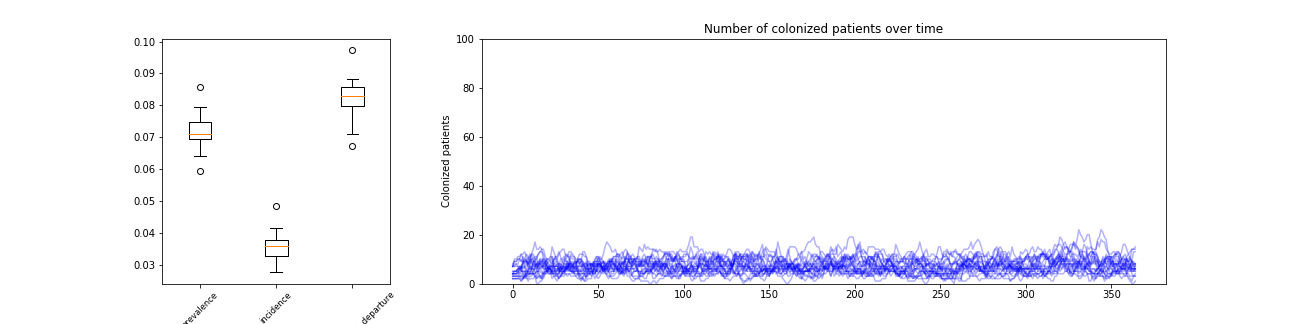

In [7]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [18, 4.5]

#wardSz = 20  # This is the value for HOSP wards
wardSz = 100  # This is the value for ICU wards
initialPrev = 0.05
fracArrivingColonized = 0.05  # UCIM ICU
#fracArrivingColonized = 0.01
tau = 0.00065
runDays = 365
instances = 20
fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs = simulate(wardSz, initialPrev, fracArrivingColonized,
                                                                      tau, runDays, instances, losCRV=icuCRV)

print 'median incidence = %f' % fracIncidenceL[len(fracIncidenceL)//2]
print 'median prevalence = %f' % fracPrevalenceL[len(fracPrevalenceL)//2]
print 'median colonized departure fraction = %f' % fracColDepartL[len(fracColDepartL)//2]
plotWard(fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs, wardSz)

median incidence = 0.035117
median prevalence = 0.066895
median colonized departure fraction = 0.082456


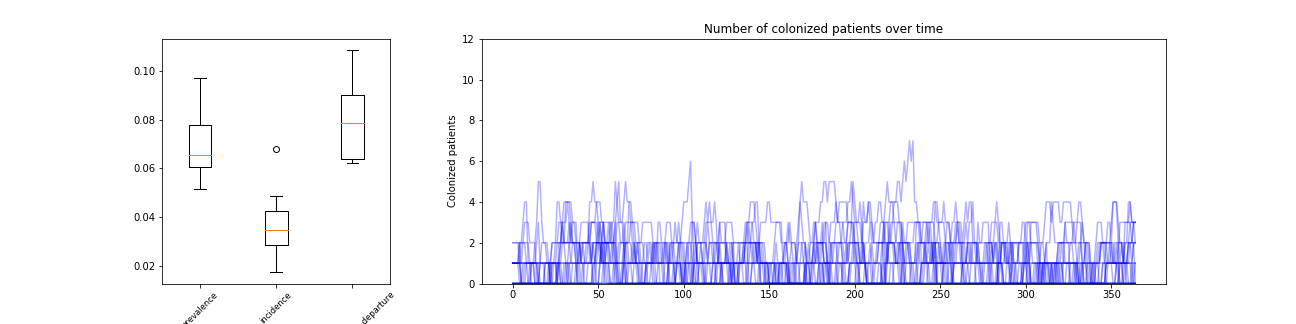

In [8]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [18, 4.5]

wardSz = 12  # This is the value for ICU wards
#wardSz = 100  
initialPrev = 0.05
fracArrivingColonized = 0.05  # UCIM ICU
#fracArrivingColonized = 0.08
tau = 0.0055
#tau = 0.01
runDays = 365
instances = 20
fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs = simulate(wardSz, initialPrev, fracArrivingColonized,
                                                                      tau, runDays, instances, losCRV=icuCRV)

print 'median incidence = %f' % fracIncidenceL[len(fracIncidenceL)//2]
print 'median prevalence = %f' % fracPrevalenceL[len(fracPrevalenceL)//2]
print 'median colonized departure fraction = %f' % fracColDepartL[len(fracColDepartL)//2]
plotWard(fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs, wardSz)


median incidence = 0.009324
median prevalence = 0.055068
median colonized departure fraction = 0.061146


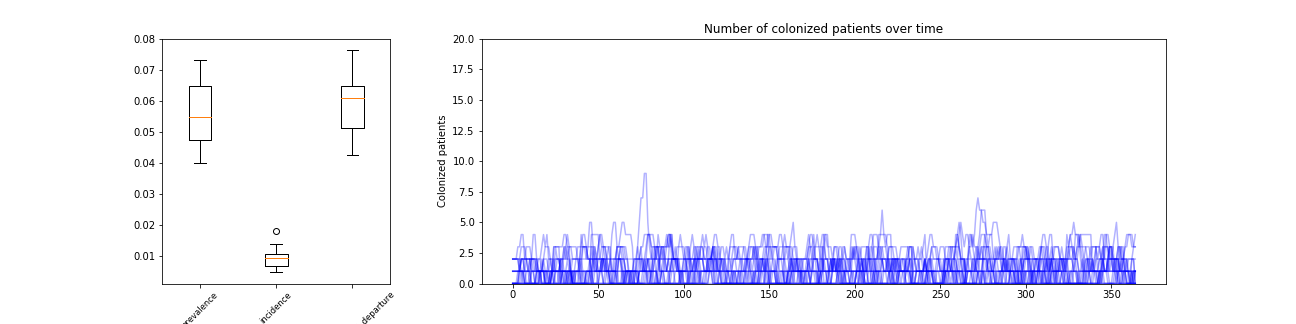

In [9]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [18, 4.5]

wardSz = 20  # This is the value for HOSP wards
#wardSz = 100  
initialPrev = 0.05
fracArrivingColonized = 0.05  # UCIM ICU
#fracArrivingColonized = 0.01
tau = 0.0017
runDays = 365
instances = 20
fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs = simulate(wardSz, initialPrev, fracArrivingColonized,
                                                                      tau, runDays, instances, losCRV=hospCRV)

print 'median incidence = %f' % fracIncidenceL[len(fracIncidenceL)//2]
print 'median prevalence = %f' % fracPrevalenceL[len(fracPrevalenceL)//2]
print 'median colonized departure fraction = %f' % fracColDepartL[len(fracColDepartL)//2]
plotWard(fracIncidenceL, fracPrevalenceL, fracColDepartL, plotPairs, wardSz)
